In [1]:
# !pip install umap-learn

In [2]:
from rdkit import Chem, DataStructs

try:
    from descriptastorus.descriptors import (CURRENT_VERSION, RDKIT_PROPS,
                                             rdDescriptors,
                                             rdNormalizedDescriptors)
except ImportError:
    raise ImportError('Failed to import descriptastorus. Please install descriptastorus via '
                      'pip install git+https://github.com/bp-kelley/descriptastorus '
                      'to use RDKit 2D features.')

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid', {'axes.edgecolor': '0.2',
                           'xtick.bottom': True,
                           'ytick.left': True
                          })

In [3]:
# add BMLC repo to Python path
# https://github.com/kspieks/BMLC/tree/main
from baseline_models.features.featurizers import calc_atompair_fp, calc_rdkit_2d_fp, calc_rdkit_2d_normalized_fp

# Read in data

In [4]:
df = pd.read_csv('data/ESOL/delaney.csv')
df

,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


In [5]:
def is_ring_aromatic(mol, bond_ring):
    """
    Helper function for identifying if a bond is aromatic

    Args:
        mol: rdkit molecule 
        bond_ring: rdkit bond from a ring

    Returns:
        True if the bond is in an aromatic ring. False otherwise
    """
    for idx in bond_ring:
        if not mol.GetBondWithIdx(idx).GetIsAromatic():
            return False
    return True

In [6]:
def identify_aromatic_rings(smi):
    mol = Chem.MolFromSmiles(smi)
    # display(mol)
    all_ring_bonds = mol.GetRingInfo().BondRings()
    # print(all_ring_bonds)
    for ring_bonds in all_ring_bonds:
        if is_ring_aromatic(mol, ring_bonds):
            return True
    return False

In [7]:
smi = df.smiles.values[0]
identify_aromatic_rings(smi)

True

In [8]:
df['contains_aromatic'] = df.smiles.apply(identify_aromatic_rings)
df

,smiles,logSolubility,contains_aromatic
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,True
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,True
2,CC(C)=CCCC(C)=CC(=O),-2.060,False
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,True
4,c1ccsc1,-1.330,True
...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,False
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,False
1125,CCSCCSP(=S)(OC)OC,-3.091,False
1126,CCC(C)C,-3.180,False


In [9]:
df['label'] = df.contains_aromatic.mask(df.contains_aromatic.values, other='aromatic')
df['label'] = df.label.mask(~df.contains_aromatic.values, other='Not aromatic')

In [10]:
df

,smiles,logSolubility,contains_aromatic,label
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,True,aromatic
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,True,aromatic
2,CC(C)=CCCC(C)=CC(=O),-2.060,False,Not aromatic
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,True,aromatic
4,c1ccsc1,-1.330,True,aromatic
...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,False,Not aromatic
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,False,Not aromatic
1125,CCSCCSP(=S)(OC)OC,-3.091,False,Not aromatic
1126,CCC(C)C,-3.180,False,Not aromatic


In [11]:
df.label.value_counts()

label
aromatic        662
Not aromatic    466
Name: count, dtype: int64

In [12]:
df.label.value_counts().sum()

1128

# Featurize molecules

Or just do morgan count fingerprints or RDKit count fingerprints

## Add AtomPair fingerprint

In [13]:
fpSize = 1024
ap_fps = np.stack(df.smiles.apply(calc_atompair_fp, fpSize=fpSize))
ap_fps.shape

(1128, 1024)

In [14]:
column_names = [f'bit{i}' for i in range(fpSize)]
df_ap = pd.DataFrame(ap_fps, columns = column_names)
df_ap

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit1014,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,9.0,0.0,0.0,0.0,9.0,4.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Add molecular fingerprint

In [15]:
moe_2d_fps = np.stack(df.smiles.apply(calc_rdkit_2d_fp, properties=RDKIT_PROPS[CURRENT_VERSION]))
# moe_2d_fps = np.stack(df.smiles.apply(calc_rdkit_2d_normalized_fp, properties=None))
moe_2d_fps.shape

(1128, 200)

In [16]:
generator = rdNormalizedDescriptors.RDKit2DNormalized(properties=RDKIT_PROPS[CURRENT_VERSION])
generator.columns

[('BalabanJ', numpy.float64),
 ('BertzCT', numpy.float64),
 ('Chi0', numpy.float64),
 ('Chi0n', numpy.float64),
 ('Chi0v', numpy.float64),
 ('Chi1', numpy.float64),
 ('Chi1n', numpy.float64),
 ('Chi1v', numpy.float64),
 ('Chi2n', numpy.float64),
 ('Chi2v', numpy.float64),
 ('Chi3n', numpy.float64),
 ('Chi3v', numpy.float64),
 ('Chi4n', numpy.float64),
 ('Chi4v', numpy.float64),
 ('EState_VSA1', numpy.float64),
 ('EState_VSA10', numpy.float64),
 ('EState_VSA11', numpy.float64),
 ('EState_VSA2', numpy.float64),
 ('EState_VSA3', numpy.float64),
 ('EState_VSA4', numpy.float64),
 ('EState_VSA5', numpy.float64),
 ('EState_VSA6', numpy.float64),
 ('EState_VSA7', numpy.float64),
 ('EState_VSA8', numpy.float64),
 ('EState_VSA9', numpy.float64),
 ('ExactMolWt', numpy.float64),
 ('FpDensityMorgan1', numpy.float64),
 ('FpDensityMorgan2', numpy.float64),
 ('FpDensityMorgan3', numpy.float64),
 ('FractionCSP3', numpy.float64),
 ('HallKierAlpha', numpy.float64),
 ('HeavyAtomCount', numpy.float64),
 ('

In [17]:
column_names = [c[0] for c in generator.columns]
df_moe_2d = pd.DataFrame(moe_2d_fps, columns=column_names)
df_moe_2d = df_moe_2d.drop(['Ipc'], axis=1)
df_moe_2d

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,1.654937,759.662938,23.413485,16.862520,16.862520,15.277295,9.998816,9.998816,7.601218,7.601218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217518
1,2.148162,459.484175,10.673362,8.357948,8.357948,7.270857,4.676643,4.676643,3.210611,3.210611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.811283
2,3.625760,171.311799,8.690234,7.554513,7.554513,5.163902,3.908188,3.908188,2.969252,2.969252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343706
3,2.041379,1071.547817,14.518297,12.082904,12.082904,10.915816,7.636751,7.636751,5.829201,5.829201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291526
4,3.125000,60.124818,3.535534,2.717649,3.534146,2.500000,1.471405,2.414214,0.793148,1.609645,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.448927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,3.541197,58.445472,6.077350,2.967173,5.309098,2.943376,1.292058,2.644169,0.842309,2.721600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.523506
1124,4.399366,252.564575,11.137828,8.527420,9.343917,6.523274,3.748960,4.973705,2.428888,3.223835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293876
1125,3.522395,145.728624,9.449747,7.609775,10.953692,5.681981,3.619926,9.003460,1.842509,9.879832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.506070
1126,2.539539,14.000000,4.284457,4.284457,4.284457,2.270056,2.270056,2.270056,1.802095,1.802095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444441


## Combine them

In [18]:
df_fp = pd.concat((df_ap, df_moe_2d), axis=1)
df_fp

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217518
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.811283
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343706
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291526
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.448927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.523506
1124,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293876
1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.506070
1126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444441


In [19]:
X = df_fp.values
X.shape

(1128, 1223)

# UMAP

In [20]:
umap_model = umap.UMAP(metric='jaccard',
                       n_neighbors=25,
                       n_components=2,
                       low_memory=False,
                       min_dist=0.001,
                       random_state=42,
                      )

In [21]:
X_umap = umap_model.fit_transform(X)
X_umap.shape

/Users/kevin/opt/anaconda3/envs/bmlc/lib/python3.11/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/kevin/opt/anaconda3/envs/bmlc/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(1128, 2)

In [22]:
df['UMAP 1'] = X_umap[:, 0]
df['UMAP 2'] = X_umap[:, 1]
df

,smiles,logSolubility,contains_aromatic,label,UMAP 1,UMAP 2
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,True,aromatic,9.762455,4.303389
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,True,aromatic,8.120844,6.391593
2,CC(C)=CCCC(C)=CC(=O),-2.060,False,Not aromatic,3.966223,2.259595
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,True,aromatic,8.333947,11.504870
4,c1ccsc1,-1.330,True,aromatic,9.036991,11.707613
...,...,...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,False,Not aromatic,0.018175,4.532961
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,False,Not aromatic,7.897742,7.010031
1125,CCSCCSP(=S)(OC)OC,-3.091,False,Not aromatic,3.036806,2.730823
1126,CCC(C)C,-3.180,False,Not aromatic,-2.010694,3.327294


Text(0.5, 1.0, 'UMAP Embedding')

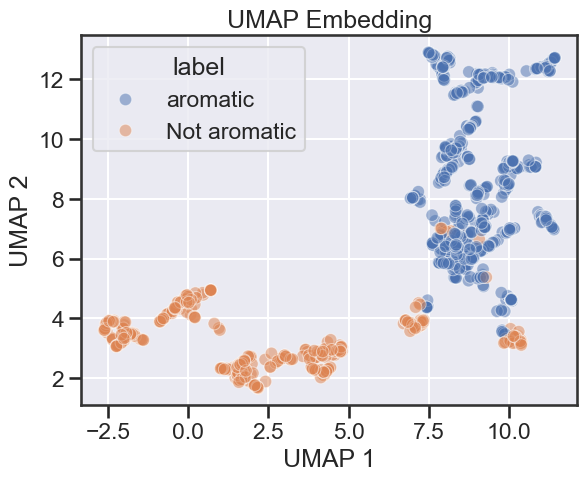

In [23]:
method = 'UMAP'
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
)
ax.set_title(f'{method} Embedding')

In [24]:
# inspect the non-aromatic molecules that are within the aromatic cluster 
df_tmp = (df
          .query('`UMAP 1` > 7.5')
          .query('`UMAP 1` < 10')
          .query('`UMAP 2` < 8')
          .query('`UMAP 2` > 5')
         )
df_tmp

,smiles,logSolubility,contains_aromatic,label,UMAP 1,UMAP 2
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,True,aromatic,8.120844,6.391593
18,CCOP(=S)(OCC)Oc1cc(C)nc(n1)C(C)C,-3.640,True,aromatic,9.931355,6.911833
23,CCOc1ccc(NC(=O)C)cc1,-2.350,True,aromatic,7.964162,6.820030
32,COC(=O)Nc1cccc(OC(=O)Nc2cccc(C)c2)c1,-4.805,True,aromatic,8.374134,6.536253
37,CN(C)C(=O)SCCCCOc1ccccc1,-3.927,True,aromatic,9.117588,7.068459
...,...,...,...,...,...,...
1107,Cc1cc(no1)C(=O)NNCc2ccccc2,-2.461,True,aromatic,8.372700,6.140506
1110,CCOC(=O)Nc2cccc(OC(=O)Nc1ccccc1)c2,-4.632,True,aromatic,8.329393,6.406748
1113,CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1,-2.281,True,aromatic,8.353210,6.460034
1117,NS(=O)(=O)c1cc(ccc1Cl)C2(O)NC(=O)c3ccccc23,-3.451,True,aromatic,7.955842,5.848128


In [25]:
df_tmp.label.value_counts()

label
aromatic        214
Not aromatic      7
Name: count, dtype: int64

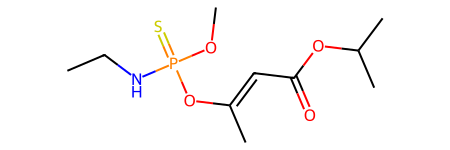

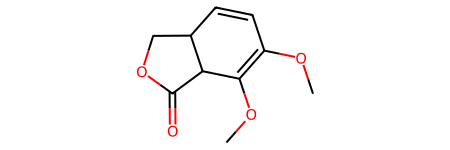

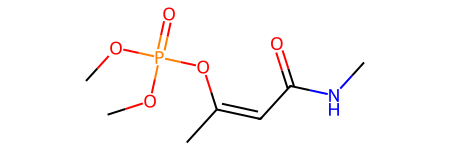

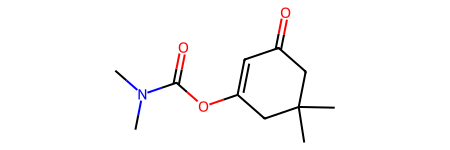

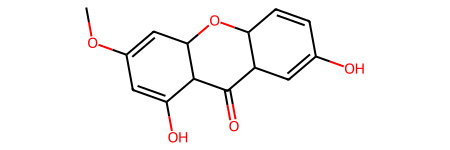

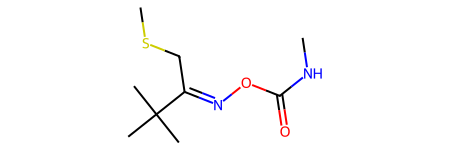

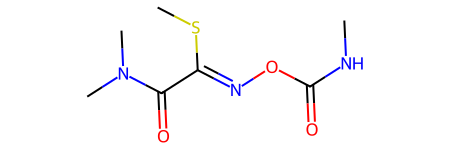

In [27]:
# I guess UMAP is clustering based on double bonds?
for i, row in df_tmp.query('label == "Not aromatic"').iterrows():
    print('')
    mol = Chem.MolFromSmiles(row.smiles)
    display(mol)

Text(0.5, 1.0, 'UMAP Embedding')

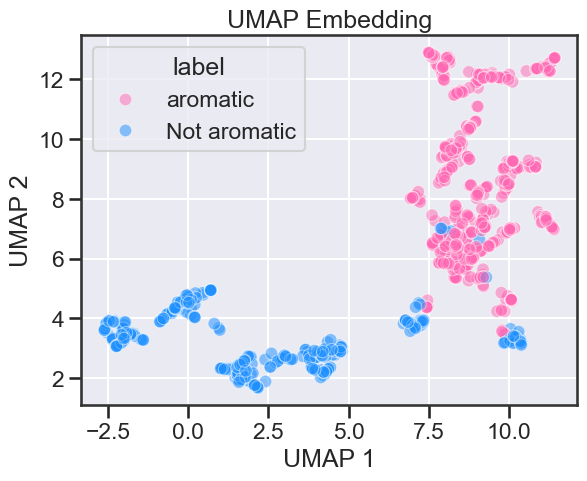

In [30]:
method = 'UMAP'
palette = sns.color_palette(['hotpink', 'dodgerblue'])
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
                palette=palette,
)
ax.set_title(f'{method} Embedding')

# PCA

In [31]:
pca = PCA(300)
X_pca = pca.fit_transform(X)

In [32]:
print(f'{pca.explained_variance_ratio_.sum():.3f} variance explained overall')
print(f'{pca.explained_variance_ratio_[:2].sum():.3f} variance explained by the first 2 PCs')

1.000 variance explained overall
0.937 variance explained by the first 2 PCs


In [24]:
X_pca.shape

(1128, 300)

In [25]:
df['PCA 1'] = X_pca[:, 0]
df['PCA 2'] = X_pca[:, 1]
df

,label,UMAP 1,UMAP 2,PCA 1,PCA 2
0,aromatic,8.976984,3.867337,619.206409,170.534465
1,aromatic,7.789079,6.407802,110.763281,-77.385500
2,Not aromatic,1.675957,3.295589,-184.447948,2.331342
3,aromatic,9.973267,11.084851,705.479275,-286.295941
4,aromatic,8.923738,11.619379,-346.097975,-44.696993
...,...,...,...,...,...
1123,Not aromatic,-0.178358,6.899083,-246.503643,127.283914
1124,Not aromatic,7.980118,6.902246,-50.704800,66.463220
1125,Not aromatic,1.018529,3.908322,-120.462644,162.243198
1126,Not aromatic,-2.456068,6.658580,-398.836938,-33.480473


Text(0.5, 1.0, 'Unscaled PCA Embedding')

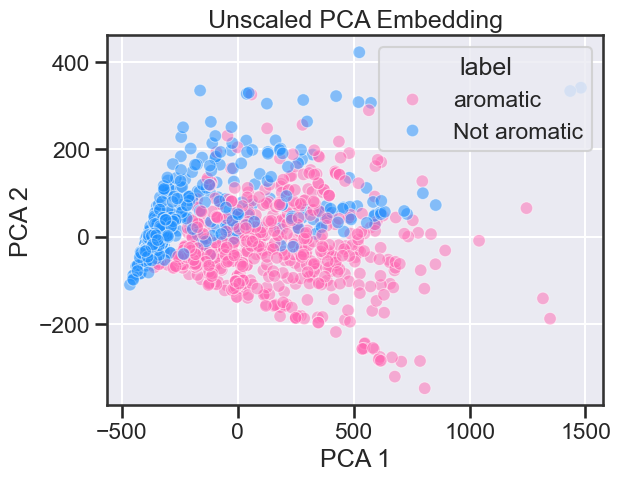

In [26]:
method = 'PCA'
palette = sns.color_palette(['hotpink', 'dodgerblue'])
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
                palette=palette,
)
ax.set_title(f'Unscaled {method} Embedding')

In [27]:
df_pca_importance = pd.DataFrame({'features': df_fp.columns,
                                  'PC1_importance': pca.components_[0, :],
                                  'PC2_importance': pca.components_[1, :],
                                 })
df_pca_importance

,features,PC1_importance,PC2_importance
0,bit0,0.001733,0.002039
1,bit1,0.001323,0.001961
2,bit2,0.000003,-0.000004
3,bit3,0.000010,0.000104
4,bit4,0.001293,-0.000673
...,...,...,...
1218,fr_thiocyan,0.000000,0.000000
1219,fr_thiophene,-0.000002,-0.000018
1220,fr_unbrch_alkane,-0.000430,0.004047
1221,fr_urea,0.000060,0.000125


In [28]:
print(f'PC1 importance:')
df_pca_importance.sort_values('PC1_importance', ascending=False)

PC1 importance:


,features,PC1_importance,PC2_importance
1025,BertzCT,0.842775,-0.505638
1071,MolWt,0.289259,0.465542
1049,ExactMolWt,0.288690,0.461284
1056,HeavyAtomMolWt,0.279278,0.445526
1060,LabuteASA,0.117929,0.125256
...,...,...,...
271,bit271,-0.000704,0.005411
1134,VSA_EState7,-0.001247,0.004643
1054,HallKierAlpha,-0.001882,0.006335
1067,MinEStateIndex,-0.001896,-0.004290


In [29]:
print(f'PC2 importance:')
df_pca_importance.sort_values('PC2_importance', ascending=False)

PC2 importance:


,features,PC1_importance,PC2_importance
1071,MolWt,0.289259,0.465542
1049,ExactMolWt,0.288690,0.461284
1056,HeavyAtomMolWt,0.279278,0.445526
1060,LabuteASA,0.117929,0.125256
1117,SlogP_VSA12,0.009230,0.111185
...,...,...,...
1124,SlogP_VSA8,0.007938,-0.038642
1047,EState_VSA8,0.005129,-0.043587
1122,SlogP_VSA6,0.037890,-0.099458
1111,SMR_VSA7,0.047547,-0.100234


# t-SNE with unscaled PCA embeddings

In [30]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)
X_tsne.shape

(1128, 2)

In [31]:
df['TSNE 1'] = X_tsne[:, 0]
df['TSNE 2'] = X_tsne[:, 1]
df

,label,UMAP 1,UMAP 2,PCA 1,PCA 2,TSNE 1,TSNE 2
0,aromatic,8.976984,3.867337,619.206409,170.534465,54.566845,13.799714
1,aromatic,7.789079,6.407802,110.763281,-77.385500,27.810223,-10.264165
2,Not aromatic,1.675957,3.295589,-184.447948,2.331342,-20.391714,-10.065959
3,aromatic,9.973267,11.084851,705.479275,-286.295941,55.697353,-3.862887
4,aromatic,8.923738,11.619379,-346.097975,-44.696993,-55.096378,0.929235
...,...,...,...,...,...,...,...
1123,Not aromatic,-0.178358,6.899083,-246.503643,127.283914,-25.254938,23.787899
1124,Not aromatic,7.980118,6.902246,-50.704800,66.463220,1.753021,-3.141177
1125,Not aromatic,1.018529,3.908322,-120.462644,162.243198,-5.340645,5.707154
1126,Not aromatic,-2.456068,6.658580,-398.836938,-33.480473,-49.421833,15.983100


Text(0.5, 1.0, 'Unscaled TSNE Embedding')

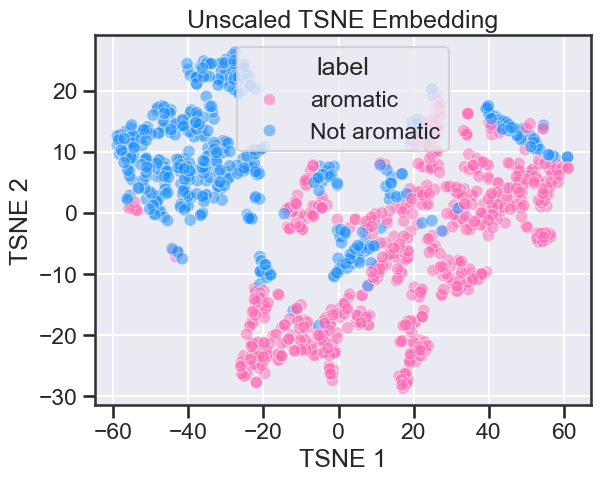

In [32]:
method = 'TSNE'
palette = sns.color_palette(['hotpink', 'dodgerblue'])
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
                palette=palette,
)
ax.set_title(f'Unscaled {method} Embedding')

# PCA Scaled

In [33]:
pca = PCA(300)
scaler = StandardScaler()

In [34]:
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(1128, 300)

In [35]:
print(f'{pca.explained_variance_ratio_.sum():.3f} variance explained overall')
print(f'{pca.explained_variance_ratio_[:2].sum():.3f} variance explained by the first 2 PCs')

0.960 variance explained overall
0.162 variance explained by the first 2 PCs


In [36]:
df['Scaled PCA 1'] = X_pca[:, 0]
df['Scaled PCA 2'] = X_pca[:, 1]
df

,label,UMAP 1,UMAP 2,PCA 1,PCA 2,TSNE 1,TSNE 2,Scaled PCA 1,Scaled PCA 2
0,aromatic,8.976984,3.867337,619.206409,170.534465,54.566845,13.799714,40.238637,-1.334440
1,aromatic,7.789079,6.407802,110.763281,-77.385500,27.810223,-10.264165,-1.944747,-0.811225
2,Not aromatic,1.675957,3.295589,-184.447948,2.331342,-20.391714,-10.065959,-3.353341,1.924230
3,aromatic,9.973267,11.084851,705.479275,-286.295941,55.697353,-3.862887,-1.023032,-2.010617
4,aromatic,8.923738,11.619379,-346.097975,-44.696993,-55.096378,0.929235,-6.377229,5.626629
...,...,...,...,...,...,...,...,...,...
1123,Not aromatic,-0.178358,6.899083,-246.503643,127.283914,-25.254938,23.787899,-4.420494,3.671484
1124,Not aromatic,7.980118,6.902246,-50.704800,66.463220,1.753021,-3.141177,0.420900,-0.607197
1125,Not aromatic,1.018529,3.908322,-120.462644,162.243198,-5.340645,5.707154,0.305458,2.517686
1126,Not aromatic,-2.456068,6.658580,-398.836938,-33.480473,-49.421833,15.983100,-5.897283,5.727639


Text(0.5, 1.0, 'Scaled PCA Embedding')

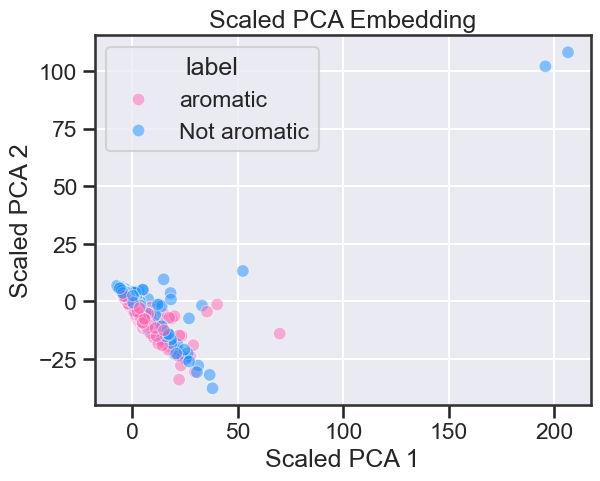

In [37]:
method = 'Scaled PCA'
palette = sns.color_palette(['hotpink', 'dodgerblue'])
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
                palette=palette,
)
ax.set_title(f'{method} Embedding')

In [38]:
df_pca_importance = pd.DataFrame({'features': df_fp.columns,
                                  'PC1_importance': pca.components_[0, :],
                                  'PC2_importance': pca.components_[1, :],
                                 })
df_pca_importance

,features,PC1_importance,PC2_importance
0,bit0,0.032031,-0.054120
1,bit1,0.042004,-0.057159
2,bit2,0.001134,-0.002815
3,bit3,0.001758,-0.002298
4,bit4,0.019655,-0.053950
...,...,...,...
1218,fr_thiocyan,0.000000,0.000000
1219,fr_thiophene,-0.001633,0.003246
1220,fr_unbrch_alkane,0.003093,0.009619
1221,fr_urea,0.003541,-0.019936


In [39]:
print(f'PC1 importance:')
df_pca_importance.sort_values('PC1_importance', ascending=False)

PC1 importance:


,features,PC1_importance,PC2_importance
197,bit197,0.073538,0.053361
560,bit560,0.073036,0.057775
839,bit839,0.072717,0.047050
458,bit458,0.072068,0.038495
72,bit72,0.071977,0.008450
...,...,...,...
1054,HallKierAlpha,-0.023725,0.060767
1065,MinAbsEStateIndex,-0.024158,0.043085
1068,MinPartialCharge,-0.025032,0.039102
1024,BalabanJ,-0.031674,0.030775


In [40]:
print(f'PC2 importance:')
df_pca_importance.sort_values('PC2_importance', ascending=False)

PC2 importance:


,features,PC1_importance,PC2_importance
914,bit914,0.068295,0.075507
79,bit79,0.068295,0.075507
908,bit908,0.068295,0.075507
737,bit737,0.068295,0.075507
512,bit512,0.068295,0.075507
...,...,...,...
1088,NumValenceElectrons,0.068754,-0.068705
1029,Chi1,0.064989,-0.070837
1055,HeavyAtomCount,0.065626,-0.071615
1025,BertzCT,0.050099,-0.071937


# t-SNE on scaled PCA componenets

In [41]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)
X_tsne.shape

(1128, 2)

In [42]:
df['TSNE of Scaled PCA Embedding 1'] = X_tsne[:, 0]
df['TSNE of Scaled PCA Embedding 2'] = X_tsne[:, 1]
df

,label,UMAP 1,UMAP 2,PCA 1,PCA 2,TSNE 1,TSNE 2,Scaled PCA 1,Scaled PCA 2,TSNE of Scaled PCA Embedding 1,TSNE of Scaled PCA Embedding 2
0,aromatic,8.976984,3.867337,619.206409,170.534465,54.566845,13.799714,40.238637,-1.334440,45.031174,-7.128500
1,aromatic,7.789079,6.407802,110.763281,-77.385500,27.810223,-10.264165,-1.944747,-0.811225,-30.173820,-19.777689
2,Not aromatic,1.675957,3.295589,-184.447948,2.331342,-20.391714,-10.065959,-3.353341,1.924230,11.953297,-1.425501
3,aromatic,9.973267,11.084851,705.479275,-286.295941,55.697353,-3.862887,-1.023032,-2.010617,-46.172668,4.321841
4,aromatic,8.923738,11.619379,-346.097975,-44.696993,-55.096378,0.929235,-6.377229,5.626629,-51.628849,8.563106
...,...,...,...,...,...,...,...,...,...,...,...
1123,Not aromatic,-0.178358,6.899083,-246.503643,127.283914,-25.254938,23.787899,-4.420494,3.671484,6.339989,24.415340
1124,Not aromatic,7.980118,6.902246,-50.704800,66.463220,1.753021,-3.141177,0.420900,-0.607197,4.463778,-9.994523
1125,Not aromatic,1.018529,3.908322,-120.462644,162.243198,-5.340645,5.707154,0.305458,2.517686,9.109484,-23.220444
1126,Not aromatic,-2.456068,6.658580,-398.836938,-33.480473,-49.421833,15.983100,-5.897283,5.727639,26.815990,7.466604


Text(0.5, 1.0, 'TSNE of Scaled PCA Embedding')

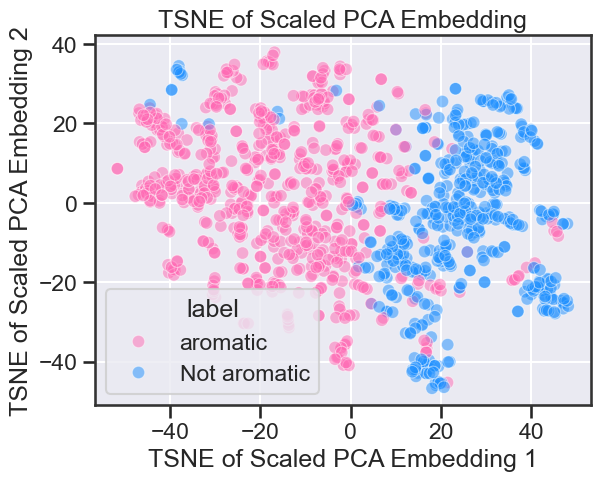

In [43]:
method = 'TSNE of Scaled PCA Embedding'
palette = sns.color_palette(['hotpink', 'dodgerblue'])
ax = sns.scatterplot(data=df,
                x=f'{method} 1',
                y=f'{method} 2',
                hue='label',
                alpha=0.5,
                palette=palette,
)
ax.set_title(f'{method}')